<a href="https://colab.research.google.com/github/Vrushabha12/DiamondPriceAnalysis/blob/main/Stock_market_next_day_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving archive (1).zip to archive (1).zip
✅ Dataset loaded successfully!
         Date Ticker  Open Price  Close Price  High Price  Low Price  \
0  01-06-2025    SLH       34.92        34.53       35.22      34.38   
1  01-06-2025    WGB      206.50       208.45      210.51     205.12   
2  01-06-2025    ZIN      125.10       124.03      127.40     121.77   
3  01-06-2025    YPY      260.55       265.28      269.99     256.64   
4  01-06-2025    VKD      182.43       186.89      189.40     179.02   

   Volume Traded    Market Cap  PE Ratio  Dividend Yield    EPS  52 Week High  \
0        2966611  5.738136e+10     29.63            2.85   1.17         39.39   
1        1658738  5.274707e+10     13.03            2.73  16.00        227.38   
2       10709898  5.596949e+10     29.19            2.64   4.25        138.35   
3       14012358  7.964089e+10     19.92            1.29  13.32        317.57   
4       14758143  7.271437e+10     40.18            1.17   4.65        243.54   

   52 W

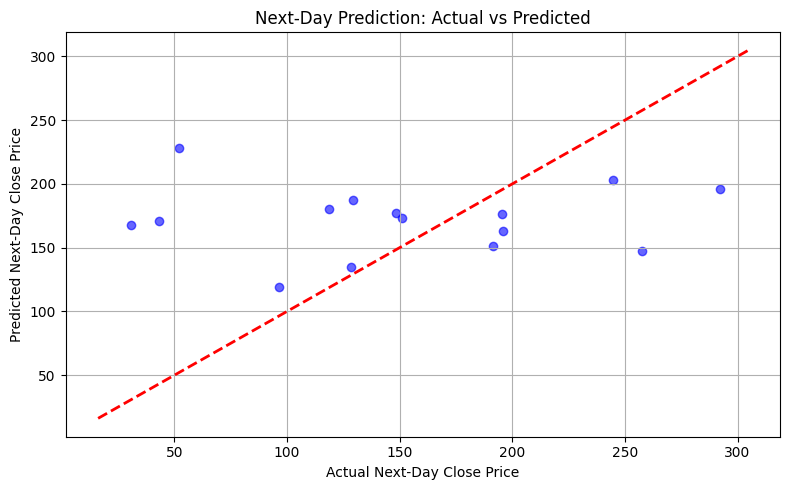

In [2]:
# === 1. Import Libraries ===
import pandas as pd
import numpy as np
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# === 2. Upload ZIP File (For Google Colab) ===
from google.colab import files
uploaded = files.upload()

# Get uploaded file name
zip_path = list(uploaded.keys())[0]
extract_path = "/content/"

# === 3. Extract ZIP File ===
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# === 4. Find CSV File ===
csv_file_path = None
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith("stock_market_june2025.csv"):
            csv_file_path = os.path.join(root, file)

if not csv_file_path:
    raise FileNotFoundError("❌ stock_market_june2025.csv not found after extraction.")

# === 5. Load Dataset ===
df = pd.read_csv(csv_file_path)
print("✅ Dataset loaded successfully!")
print(df.head())

# === 6. Preprocess Data ===
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values(['Ticker', 'Date'], inplace=True)

# Create "Next Close Price" as the target
df['Next Close Price'] = df.groupby('Ticker')['Close Price'].shift(-1)
df.dropna(subset=['Next Close Price'], inplace=True)

# === 7. Feature Engineering ===
df['Volume Traded'] = np.log1p(df['Volume Traded'])  # Reduce skew
df['Market Cap'] = np.log1p(df['Market Cap'])        # Reduce skew
df['High-Low Spread'] = df['High Price'] - df['Low Price']
df['Close-Open Diff'] = df['Close Price'] - df['Open Price']

# Drop irrelevant columns
df.drop(columns=['Date', 'Ticker', 'Sector'], inplace=True)
df.dropna(inplace=True)

# === 8. Define Features and Target ===
features = ['Open Price', 'High Price', 'Low Price', 'Volume Traded',
            'Market Cap', 'PE Ratio', 'Dividend Yield', 'EPS',
            '52 Week High', '52 Week Low',
            'High-Low Spread', 'Close-Open Diff']
X = df[features]
y = df['Next Close Price']

# === 9. Check Correlation (Optional Diagnostic) ===
print("\n📌 Top Correlations with Next Close Price:")
print(df[features + ['Next Close Price']].corr()['Next Close Price'].sort_values(ascending=False))

# === 10. Train-Test Split ===
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 11. Train Model ===
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# === 12. Predict & Evaluate ===
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print("\n📊 Next-Day Close Price Prediction:")
print(f"R² Score : {r2:.4f}")
print(f"RMSE     : {rmse:.4f}")
print(f"MAE      : {mae:.4f}")

# === 13. Plot Actual vs Predicted ===
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel("Actual Next-Day Close Price")
plt.ylabel("Predicted Next-Day Close Price")
plt.title("Next-Day Prediction: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()
